# Clustering Assignment WiSe2024

### Bachelor programme AAI-B3
### Module: Unsupervised and Reinforcement Learning
### TH Rosenheim




## Context

The dataset provided represents _customer transaction data_ for an e-commerce platform. Each row contains details about an individual customer’s purchasing behavior and demographics, while each column represents a different feature of that behavior or characteristic. 

Columns are:

- CustomerID
- Gender
- Age
- Annual Income (k$)
- Spending Score (1-100)


The goal is to segment the customers into distinct groups based on their data. These segments can help the e-commerce platform better understand their customers, enabling targeted marketing strategies, personalized recommendations, and improved customer satisfaction.

**Assignment: Clustering Analysis with K-Means, Agglomerative Clustering, and DBSCAN**

In [21]:
%matplotlib inline 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings

warnings.filterwarnings('ignore')


In [22]:
df = pd.read_csv('./customers.csv')
df.head()


,CustomerID,Gender,Age,Annual_Income,Spending_Score
0,1,Male,19.0,15.0,39.0
1,2,Male,21.0,15.0,81.0
2,3,Female,20.0,16.0,6.0
3,4,Female,23.0,16.0,77.0
4,5,Female,31.0,17.0,40.0


# Step1: Analyze and clean the data

Let's viualize the data and select the most important features

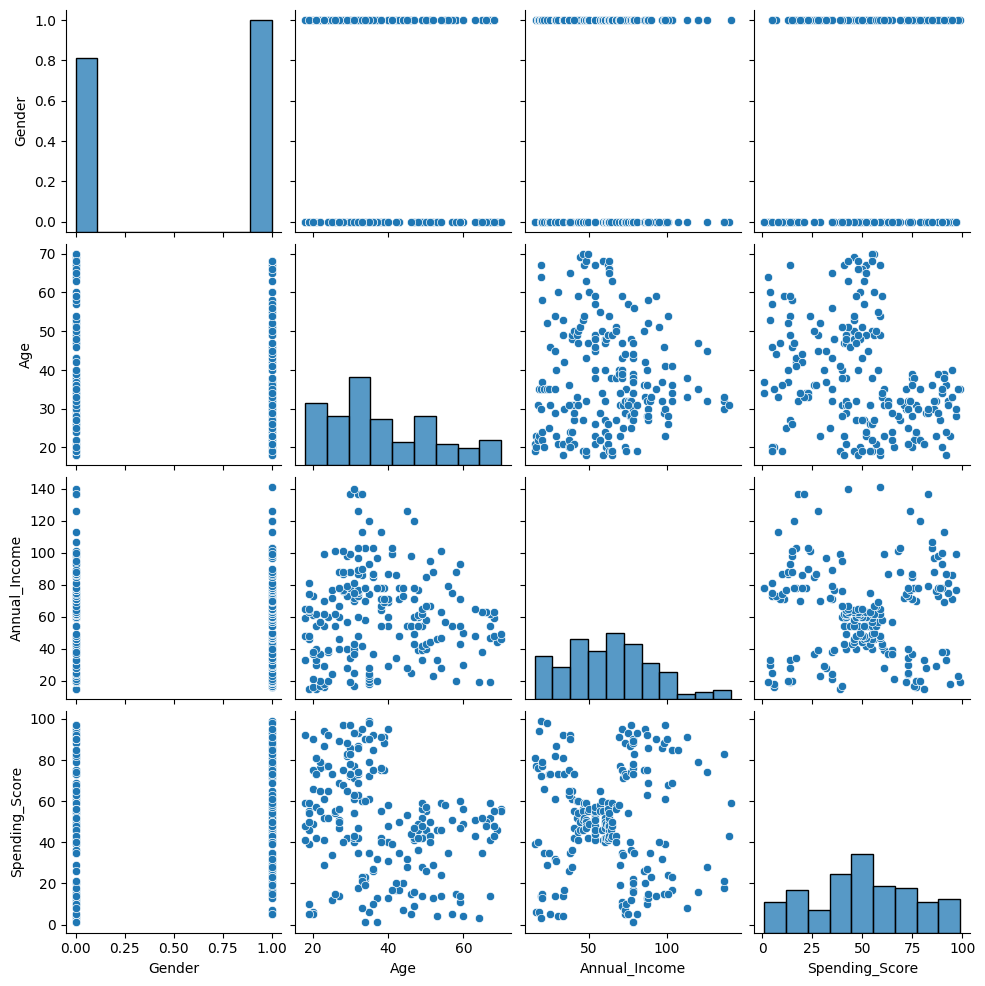

In [23]:
df = df[["Gender", "Age", "Annual_Income", "Spending_Score"]]

# Gender is categorical, so we should encode it
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

sns.pairplot(df)

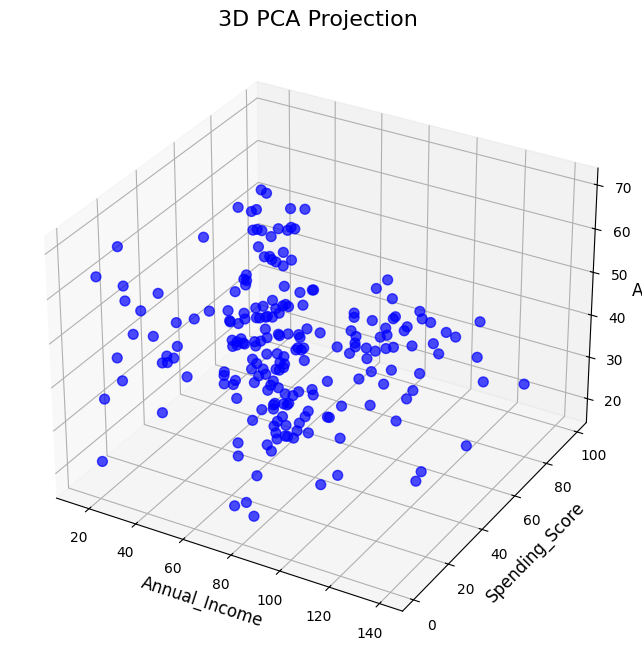

In [24]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df["Annual_Income"], df["Spending_Score"], df["Age"], c='blue', s=50, alpha=0.7)

ax.set_title("3D PCA Projection", fontsize=16)
ax.set_xlabel("Annual_Income", fontsize=12)
ax.set_ylabel("Spending_Score", fontsize=12)
ax.set_zlabel("Age", fontsize=12)

plt.show()


Let's use `Annual_Income` and `Spending_Score` for clustering, since they show clear groupings and higher variability in the plots above and capture key aspects of customer behavior: `Annual_Income` determines spending capacity, while `Spending_Score` reflects engagement or loyalty of the customers.


In [25]:
columns = ["Annual_Income", "Spending_Score"]
initial_df = df
df = df[columns]

print(f"Initial length of the df {len(df)}")
df.dropna(inplace=True)
print(f"Length after removing NA values: {len(df)}")


Initial length of the df 219
Length after removing NA values: 217


### Let's remove outliers and scale the data

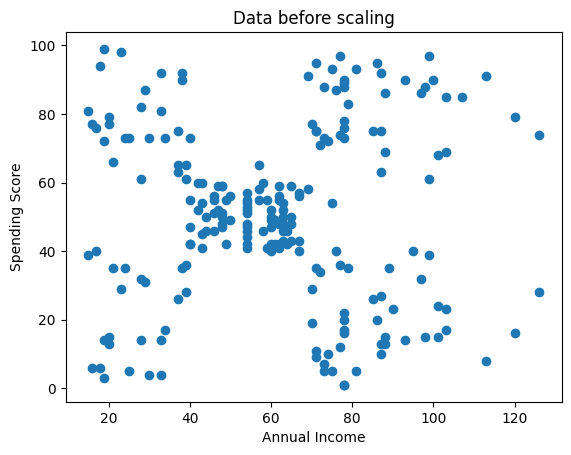

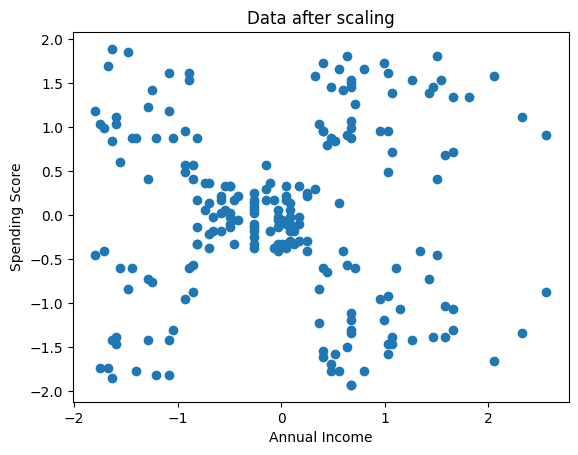

In [26]:
z_scores = np.abs(stats.zscore(df))
cluster_df_no_outliers = df[(z_scores < 3).all(axis=1)]
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Filter rows within 1.5 * IQR range
df = df[df.apply(lambda x: not ((x < (Q1 - 1.5 * IQR)) | (x > (Q3 + 1.5 * IQR))).any(), axis=1)]


plt.scatter(df["Annual_Income"], df["Spending_Score"])
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.title("Data before scaling")
plt.show()

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=columns)

plt.scatter(df["Annual_Income"], df["Spending_Score"])
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.title("Data after scaling")
plt.show()



# Step 2: Clustering

## K-Means

### Now let's use the Elbow Method and Silhouette Score to determine an optimal number of clusters

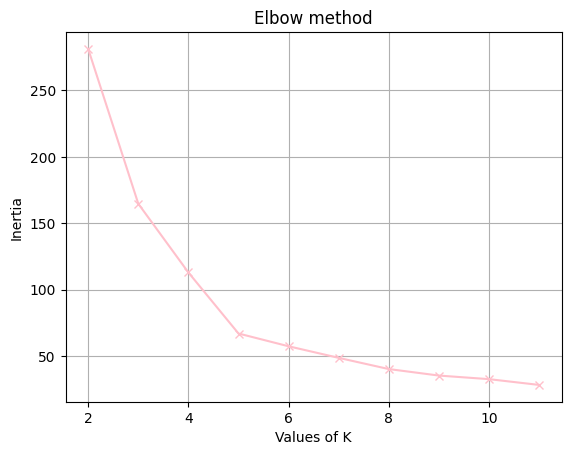

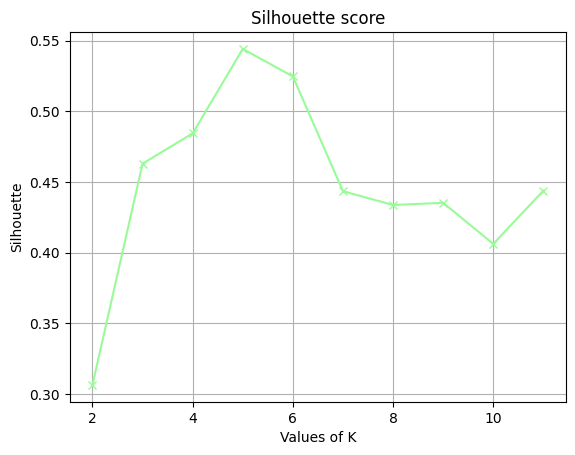

In [27]:
K = range(2, 12)
inertias = []
silhouette = []

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    cluster_labels= kmeanModel.fit_predict(df)

    silhouette.append(metrics.silhouette_score(df, cluster_labels))
    inertias.append(kmeanModel.inertia_)

plt.plot(K, inertias, 'bx-', color='pink')
plt.title("Elbow method")
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.grid()
plt.show()

plt.plot(K, silhouette, 'bx-', color='palegreen')
plt.title("Silhouette score")
plt.xlabel('Values of K')
plt.ylabel('Silhouette')
plt.grid()
plt.show()


Based on the graphs above, let's choose `k = 5`, since the inertia reduction significantly slows down after `k = 5` and the silhouette score reaches its maximum at this value, indicating the best clustering quality.

Silhouette score k-means: 0.5441544478558886


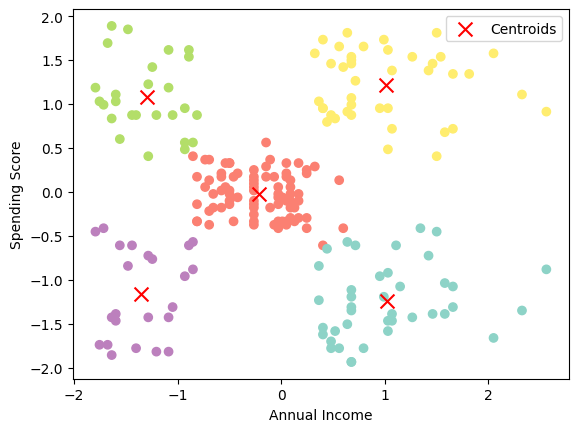

In [28]:
km = KMeans(5, random_state=42)
kmeans_labels = km.fit_predict(df)

sil_score = metrics.silhouette_score(df, kmeans_labels)
print(f"Silhouette score k-means: {sil_score}")

plt.scatter(df["Annual_Income"], df["Spending_Score"], c=kmeans_labels, cmap="Set3")
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='red', marker='x', label="Centroids")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.legend()
plt.show()



## Agglomerative clustering

### Let's find an optimal number of clusters:

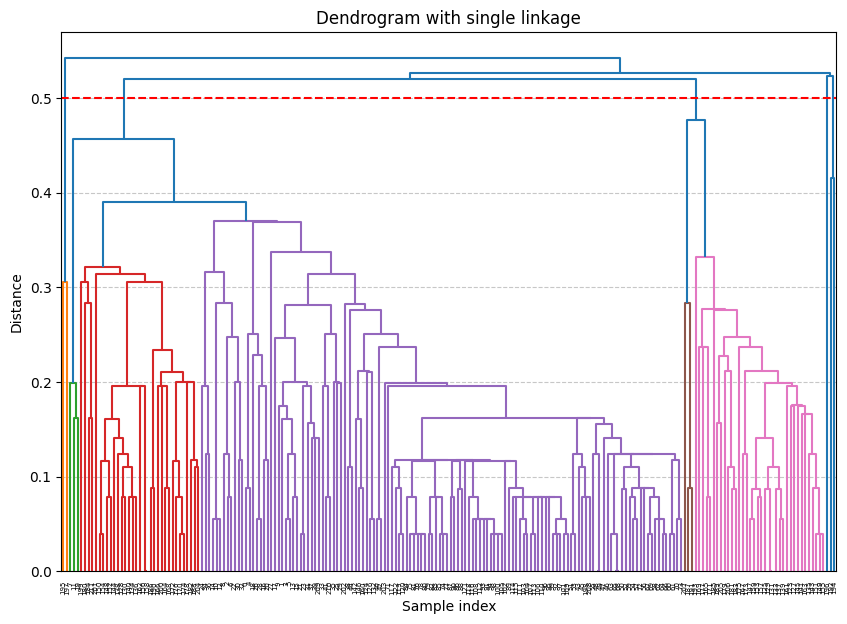

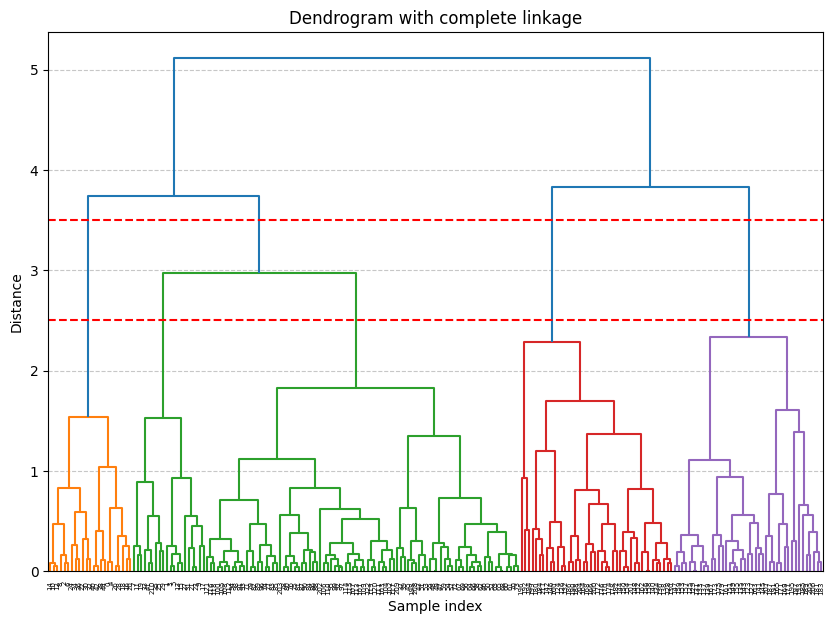

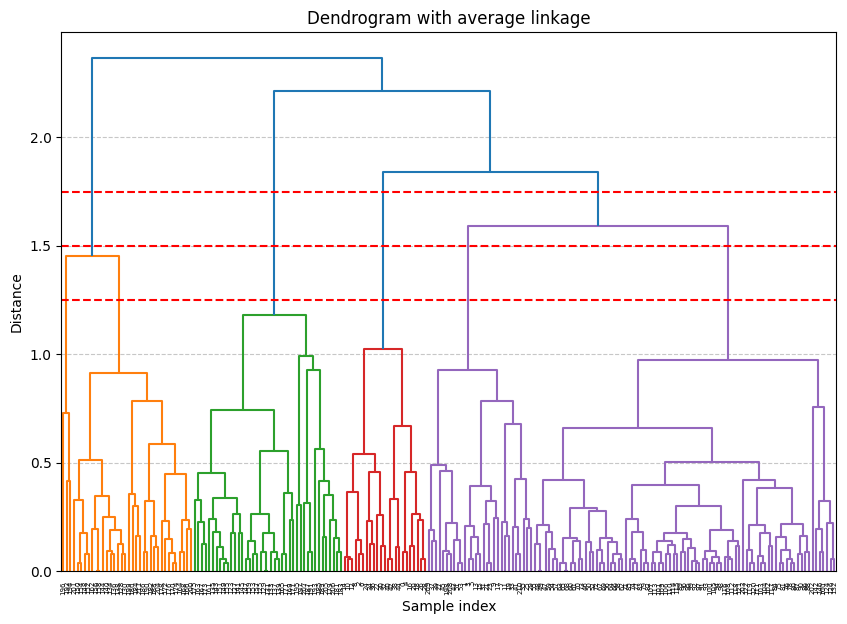

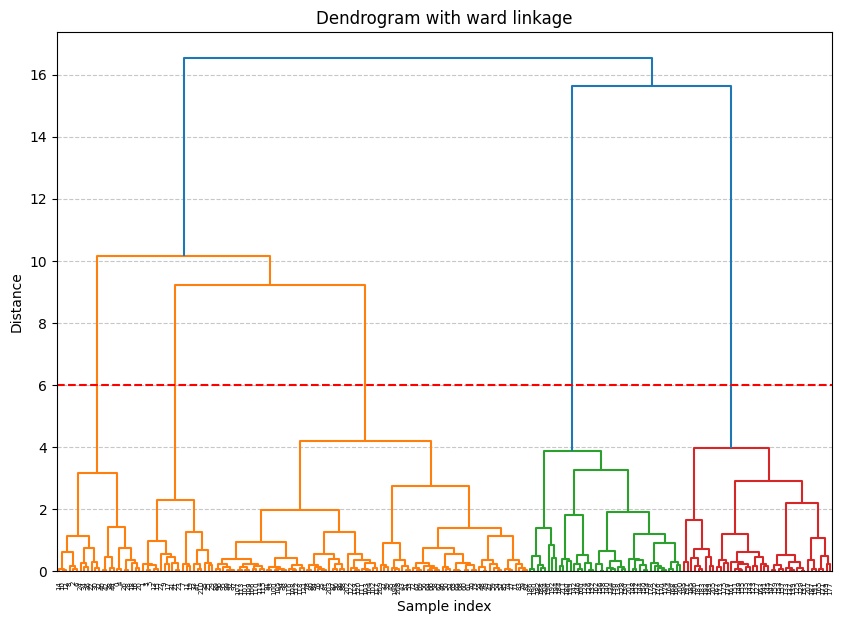

In [29]:
linkage_methods = ['single', 'complete', 'average', 'ward']
line_levels = [[0.5], [2.5, 3.5], [1.25, 1.5, 1.75], [6]]

for i, method in enumerate(linkage_methods):
    lnkg = linkage(df, method=method)
    plt.figure(figsize=(10, 7))
    dendrogram(lnkg)
    plt.title(f"Dendrogram with {method} linkage")
    plt.xlabel("Sample index")
    plt.ylabel("Distance")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for line in line_levels[i]:
        plt.axhline(y=line, color='r', linestyle='--')
    plt.show()



An optimal number of clusters in a dendrogram is determined by examining the distance at which the branches merge. An optimal number of clusters have to ensure the minimal distances within clusters and maximal separation between them. Therefore for the:

- `single linkage` an optimal number of clusters is 5 (distance = 0.5)

- `complete linkage` an optimal number of clusters is 4 or 5 (distance є [2.5, 3.5])

- `average linkage` an optimal number of clusters is from 4 to 6 (distance є [1.25, 1.75])

- `ward linkage` an optimal number of clusters is around 5 (distance = 6)

Therefore, let's choose the number of clusters equal to `5`.

### Now, let's choose an optimal linkage:



Applying Agglomerative Clustering with single linkage
Silhouette score for single linkage: 0.2550795187538953


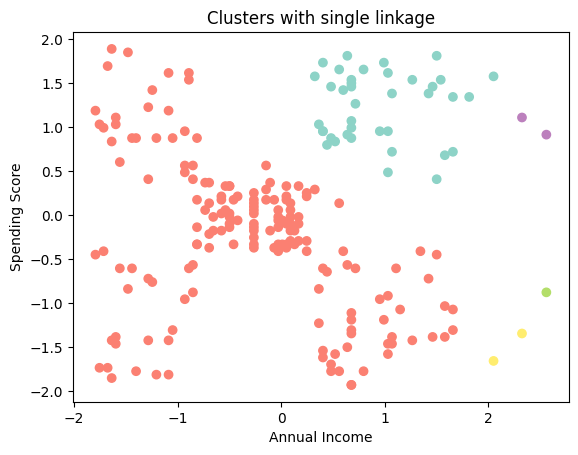



Applying Agglomerative Clustering with complete linkage
Silhouette score for complete linkage: 0.5322938566836792


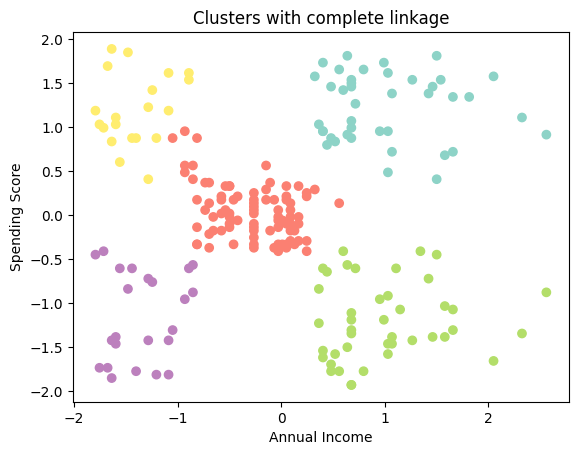



Applying Agglomerative Clustering with average linkage
Silhouette score for average linkage: 0.5337945236480315


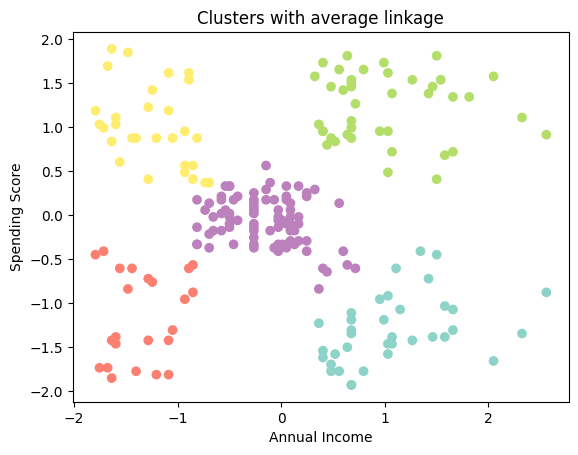



Applying Agglomerative Clustering with ward linkage
Silhouette score for ward linkage: 0.5322938566836792


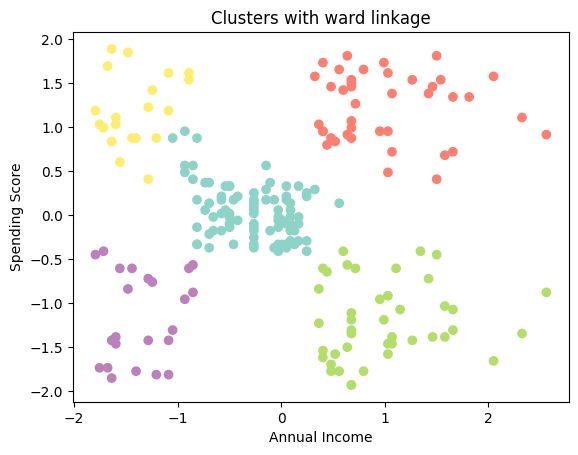

In [30]:

for method in linkage_methods:
    print(f"\n\nApplying Agglomerative Clustering with {method} linkage")

    ak = AgglomerativeClustering(n_clusters=5, linkage=method)
    labels = ak.fit_predict(df)

    silhouette_score_value = metrics.silhouette_score(df, labels)
    print(f"Silhouette score for {method} linkage: {silhouette_score_value}")

    plt.scatter(df["Annual_Income"], df["Spending_Score"], c=labels, cmap='Set3')
    plt.xlabel("Annual Income")
    plt.ylabel("Spending Score")
    plt.title(f"Clusters with {method} linkage")
    plt.show()



We can see that `single linkage` gave the worst result, while the Silhouette score for all other linkage types is better and equal to approximately 0.53 for all cases.

In [31]:
ak = AgglomerativeClustering(n_clusters=5, linkage="average")
agg_labels = ak.fit_predict(df)


## DBSCAN

### Lent's find the best parameters `eps (epsilon)` and `min_samples` using a grid search (runs around 1,5 minutes)

In [32]:
eps_range = np.arange(0.001, 4, 0.001)
min_samples_range = range(2, 10)

best_score = -1
best_params = None

for eps in eps_range:
    for min_samples in min_samples_range:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(df)
        
        if len(set(labels)) > 1:
            score = metrics.silhouette_score(df, labels)
            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

print(f"Best Parameters: eps={best_params[0]}, min_samples={best_params[1]}")
print(f"Best Silhouette Score: {best_score}")



Best Parameters: eps=0.322, min_samples=5
Best Silhouette Score: 0.42833259286981623


### Now, let's visualize clusters and identify noise points

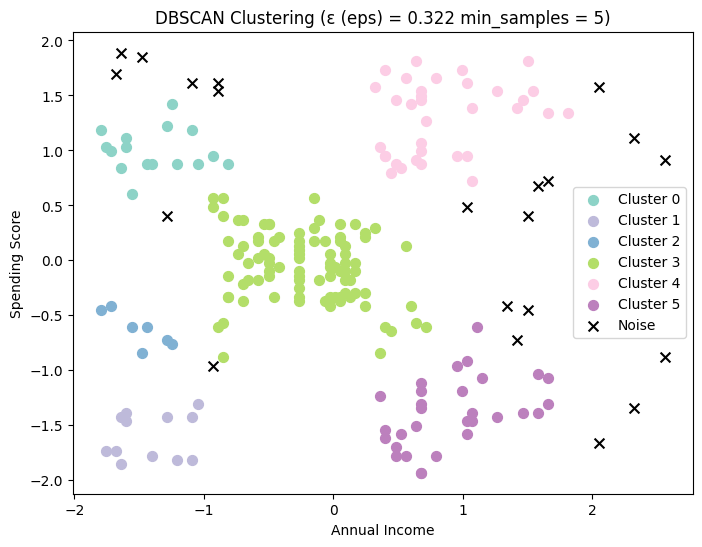

In [33]:
db = DBSCAN(eps=best_params[0], min_samples=best_params[1])
dbscan_labels = db.fit_predict(df)

plt.figure(figsize=(8, 6))
unique_labels = set(dbscan_labels)


for label in unique_labels:
    label_mask = dbscan_labels == label
    color = 'k' if label == -1 else plt.cm.Set3(float(label+0.5) / len(unique_labels))
    marker = 'x' if label == -1 else 'o'
    plt.scatter(df["Annual_Income"][label_mask], df["Spending_Score"][label_mask], c=color, s=50, label=f"Cluster {label}" if label != -1 else "Noise", marker=marker)

plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.legend()
plt.title(f"DBSCAN Clustering (ε (eps) = {best_params[0]} min_samples = {best_params[1]})")
plt.show()


# Step 3: Analysis of Results

### Compare the clusters obtained from the three methods in terms of cluster composition and size

In [34]:
def plot_clusters(labels, title=""):
    unique_labels = set(labels)
    colors = plt.cm.Set2(range(len(unique_labels)))
    cluster_sizes = [sum(labels == label) for label in unique_labels]
    bar_colors = ["k" if label == -1 else color for label, color in zip(unique_labels, colors)]

    _, axes = plt.subplots(1, 2, figsize=(16, 6))

    for label, color in zip(unique_labels, colors):
        cluster_points = df[labels == label]
        marker = "o"
        if label == -1:
            color = "k"
            marker = "x"
        axes[0].scatter(cluster_points["Annual_Income"], 
                        cluster_points["Spending_Score"], 
                        label=f"Cluster {label} (Size: {len(cluster_points)})" if label != -1 else f"Noise (Size: {len(cluster_points)})", 
                        color=color, 
                        marker=marker)

    axes[0].set_xlabel("Annual Income")
    axes[0].set_ylabel("Spending Score")
    axes[0].legend()
    axes[0].set_title(f"{title} clusters")

    bar_positions = range(len(unique_labels))
    axes[1].bar(bar_positions, cluster_sizes, color=bar_colors, alpha=0.7)
    axes[1].set_xticks(bar_positions)
    axes[1].set_xticklabels([f"Cluster {label}" if label != -1 else "Noise" for label in unique_labels])
    axes[1].set_xlabel("Clusters")
    axes[1].set_ylabel("Cluster Sizes")
    axes[1].set_title(f"{title} cluster sizes")

    plt.tight_layout()
    plt.show()
    



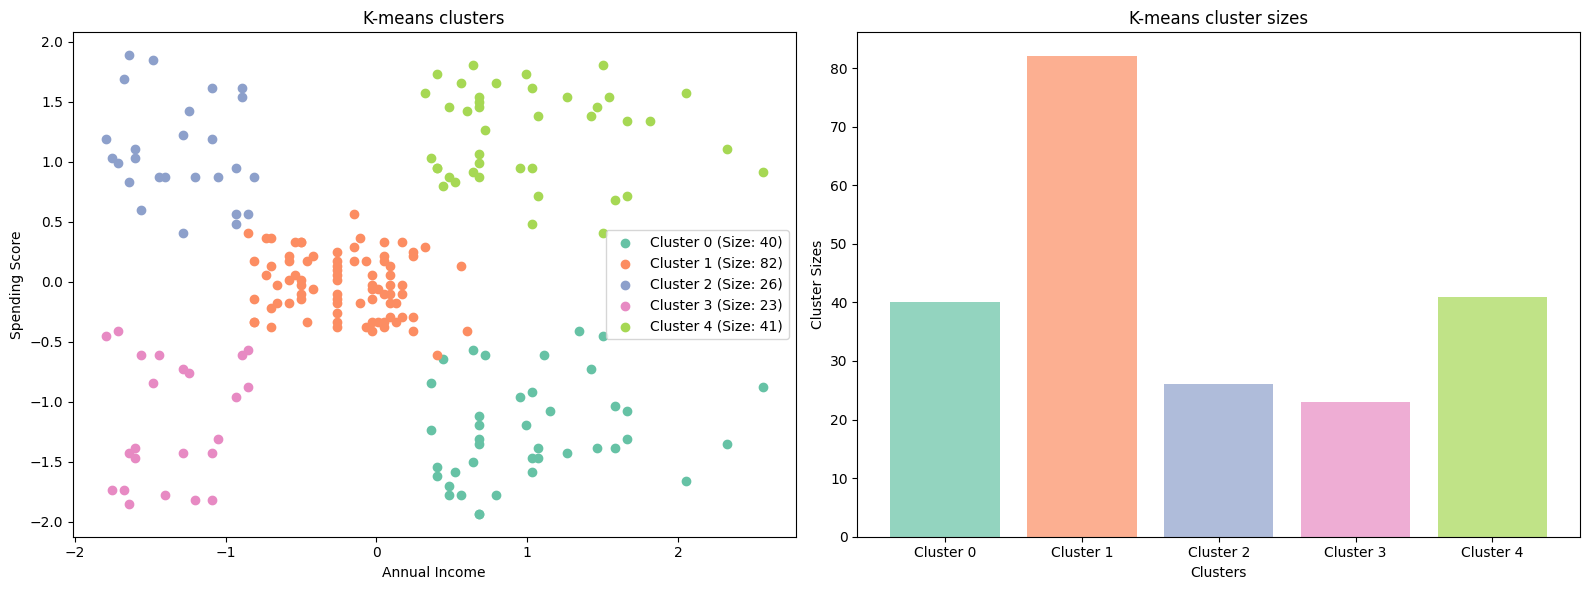

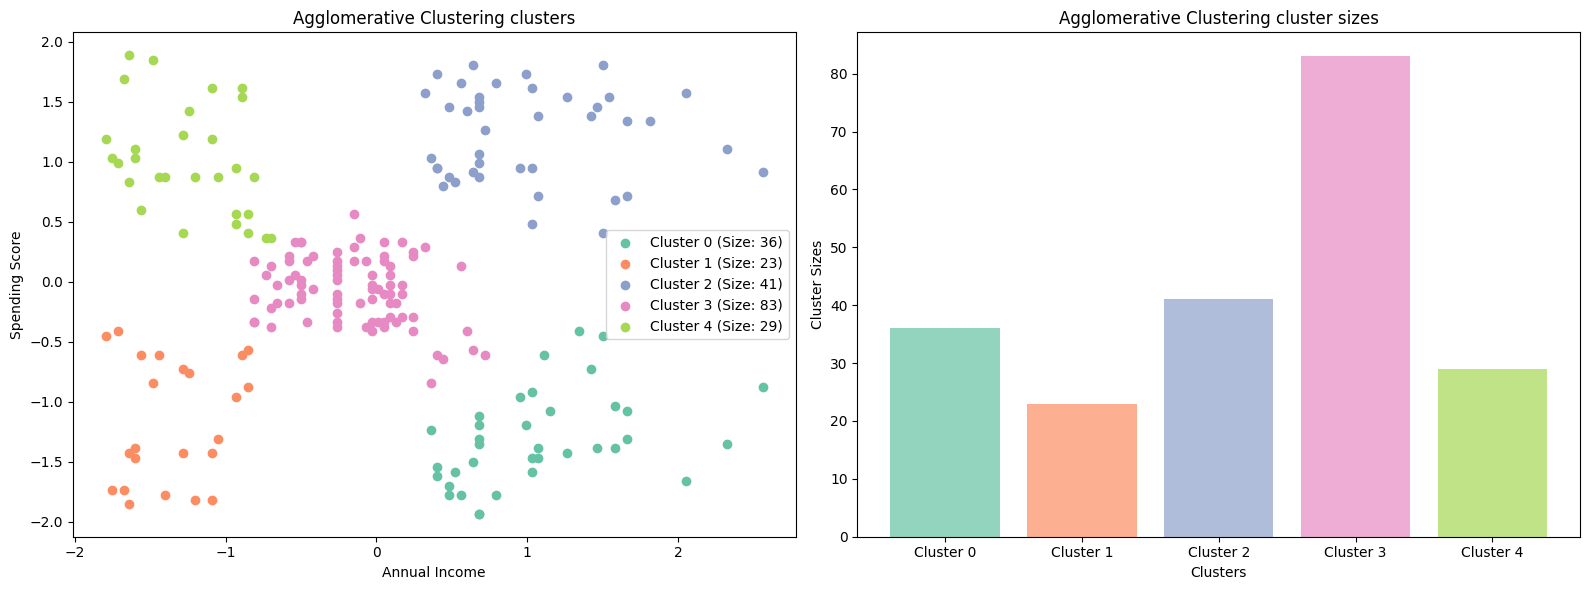

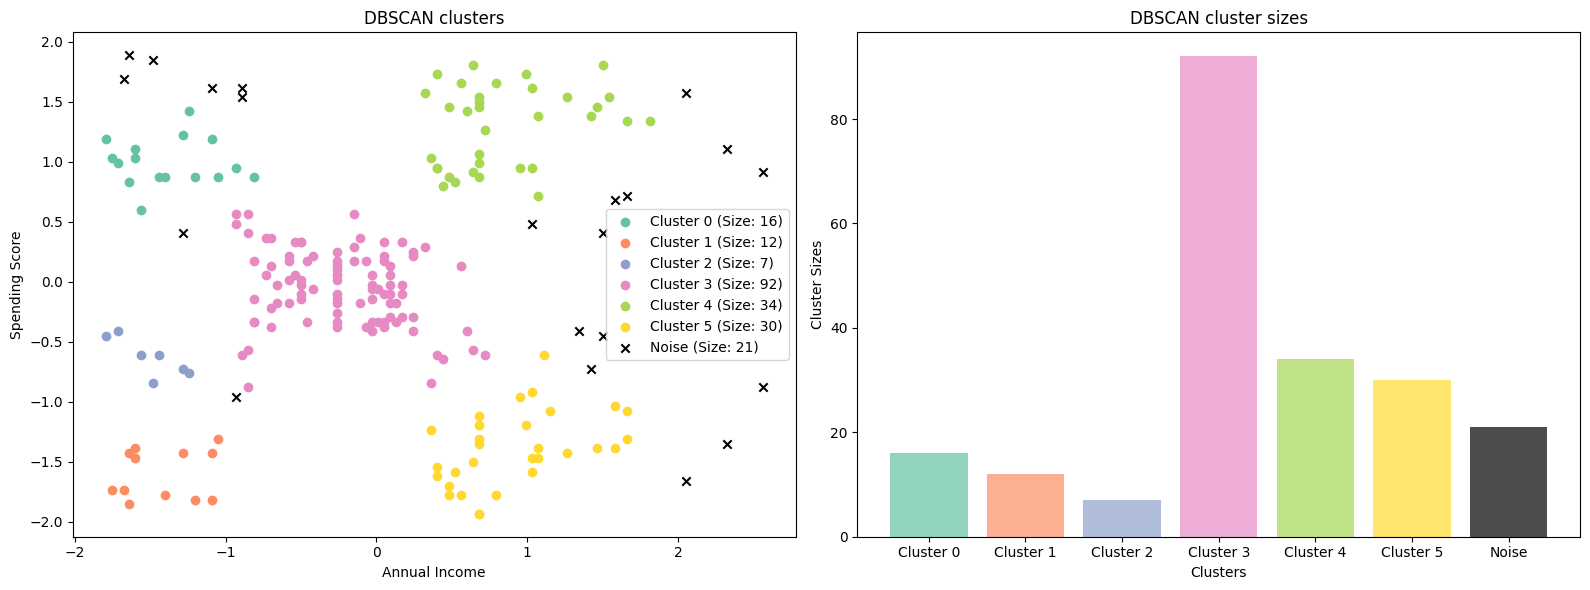

In [35]:
plot_clusters(kmeans_labels, "K-means")
plot_clusters(agg_labels, "Agglomerative Clustering")
plot_clusters(dbscan_labels, "DBSCAN")


Thus, we can make the following table containing similar clusters and their sizes:


| k-means | Size | Agglomerative Clustering | Size | DBSCAN | Size |
| --- | --- | --- | --- | --- | --- |
| Cluster 2 | 26 | Cluster 4 | 29 | Cluster 0 | 16 |
| Cluster 4 | 41 | Cluster 2 | 41 | Cluster 4 | 34 |
| Cluster 1 | 82 | Cluster 3 | 83 | Cluster 3 | 92 |
| Cluster 3 | 23 | Cluster 1 | 23 | Cluster 2 and 1 | 7 + 12 |
| Cluster 0 | 40 | Cluster 0 | 36 | Cluster 5 | 30 |


The clustering results from `K-means` and `Agglomerative Clustering` are quite similar, showing the same number of clusters with minor differences in cluster sizes. In contrast, `DBSCAN` produces one additional cluster, a larger cluster `#3`, smaller sizes for the remaining clusters, and identifies `21` data points as noise.

### Compare the clusters obtained from the three methods in terms of overlap and differences between clustering results


At this step, let's use the following metrics to evaluate the overlap and differences between clustering results: `Adjusted Rand Index (ARI)`, `Normalized Mutual Information (NMI)` and `Adjusted Mutual Information (AMI)`.

`ARI` computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters while adjusting for chance agreements. `NMI` measures the mutual information between two clusterings and normalizes the result for comparability. `AMI` is an adjustment of the `Mutual Information score` to account for chance.

In [36]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score


ari_kmeans_agg = adjusted_rand_score(kmeans_labels, agg_labels)
ari_kmeans_dbscan = adjusted_rand_score(kmeans_labels, dbscan_labels)
ari_agg_dbscan = adjusted_rand_score(agg_labels, dbscan_labels)

nmi_kmeans_agg = normalized_mutual_info_score(kmeans_labels, agg_labels)
nmi_kmeans_dbscan = normalized_mutual_info_score(kmeans_labels, dbscan_labels)
nmi_agg_dbscan = normalized_mutual_info_score(agg_labels, dbscan_labels)

ami_kmeans_agg = adjusted_mutual_info_score(kmeans_labels, agg_labels)
ami_kmeans_dbscan = adjusted_mutual_info_score(kmeans_labels, dbscan_labels)
ami_agg_dbscan = adjusted_mutual_info_score(agg_labels, dbscan_labels)



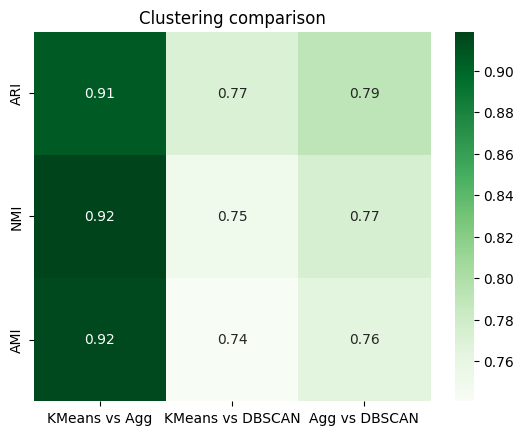

In [37]:
metrics = ['ARI', 'NMI', 'AMI']
comparisons = ['KMeans vs Agg', 'KMeans vs DBSCAN', 'Agg vs DBSCAN']

values = [
    [ari_kmeans_agg, nmi_kmeans_agg, ami_kmeans_agg],
    [ari_kmeans_dbscan, nmi_kmeans_dbscan, ami_kmeans_dbscan],
    [ari_agg_dbscan, nmi_agg_dbscan, ami_agg_dbscan],
]

sns.heatmap(np.array(values).T, annot=True, fmt=".2f", cmap="Greens", xticklabels=comparisons, yticklabels=metrics)
plt.title("Сlustering comparison")
plt.show()

Thus, we can see the high similarity between `KMeans and Agglomerative Clustering`, with all metrics above `0.9`. The agreement between `KMeans and DBSCAN`, and between `Agglomerative Clustering and DBSCAN`, is lower, with metrics around `0.74–0.79`. Which means that DBSCAN gives more different results compared to the other two methods.

### Compare the clusters obtained from the three methods in terms of Silhouette Scores and other evaluation metrics.

At this step, let's evaluate the clustering results using the following metrics: `Silhouette Score`, `Calinski-Harabasz Index`, and `Davies-Bouldin Index`.


- `Silhouette Score` quantifies how similar an object is to its own cluster compared to other clusters. It provides an indication of the density and separation of the clusters, where `higher values suggest better clustering`. Ranges from -1 to 1.


- `Calinski-Harabasz Index` evaluates the ratio of the sum of between-cluster dispersion and of within-cluster dispersion, with `higher values indicating better-defined clusters`. Ranges from 0 to +∞.


- `Davies-Bouldin Index` computes the average similarity ratio of each cluster with the cluster that is most similar to it, where `lower values indicate better clustering`. Ranges from 0 to +∞.

In [38]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

kmeans_silhouette = silhouette_score(df, kmeans_labels)
agg_silhouette = silhouette_score(df, agg_labels)
dbscan_silhouette = silhouette_score(df, dbscan_labels)

kmeans_ch = calinski_harabasz_score(df, kmeans_labels)
agg_ch = calinski_harabasz_score(df, agg_labels)
dbscan_ch = calinski_harabasz_score(df, dbscan_labels)

kmeans_db = davies_bouldin_score(df, kmeans_labels)
agg_db = davies_bouldin_score(df, agg_labels)
dbscan_db = davies_bouldin_score(df, dbscan_labels)


In [39]:
data = {
    'Silhouette Score': [kmeans_silhouette, agg_silhouette, dbscan_silhouette],
    'Calinski-Harabasz Score': [kmeans_ch, agg_ch, dbscan_ch],
    'Davies-Bouldin Score': [kmeans_db, agg_db, dbscan_db]
}

df_scores = pd.DataFrame(data, index=['KMeans', 'Agglomerative', 'DBSCAN'])

df_scores

,Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Score
KMeans,0.544154,275.224935,0.581330
Agglomerative,0.533795,267.250674,0.594578
DBSCAN,0.428333,85.485633,1.622767


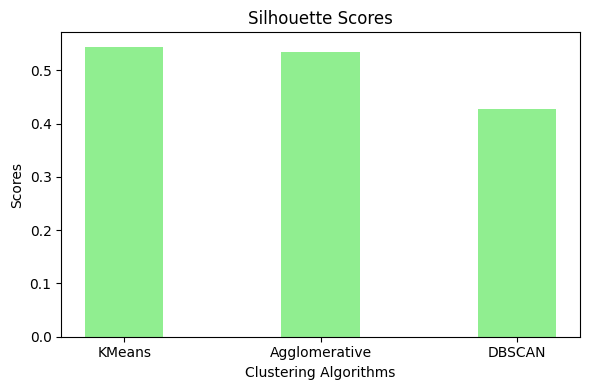

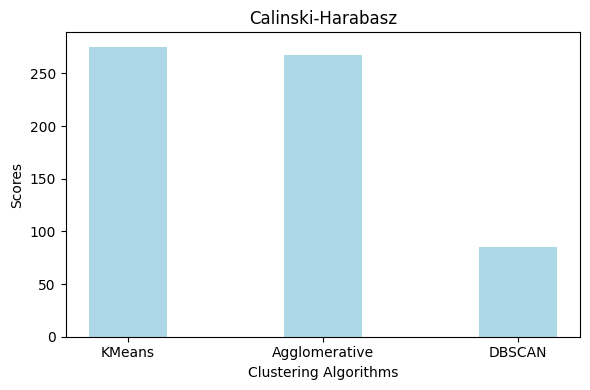

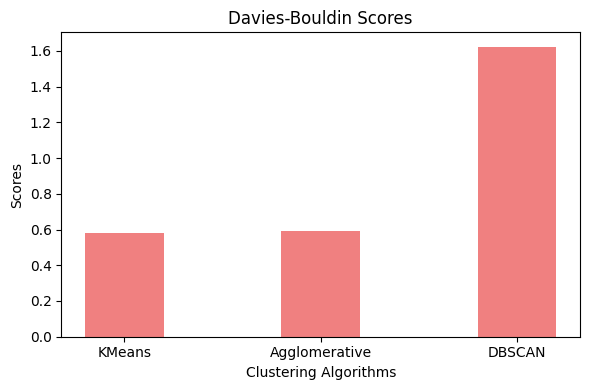

In [40]:
def plot_metrics_bars(scores, title="", color='lightgreen'):
    algorithms = ['KMeans', 'Agglomerative', 'DBSCAN']
    x = np.arange(len(algorithms))
    width = 0.4

    _, ax = plt.subplots(figsize=(6, 4))

    ax.bar(np.arange(3), scores, width, color=color)

    ax.set_xlabel('Clustering Algorithms')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(algorithms)

    plt.tight_layout()
    plt.show()


plot_metrics_bars(df_scores['Silhouette Score'], "Silhouette Scores")
plot_metrics_bars(df_scores['Calinski-Harabasz Score'], "Calinski-Harabasz", "lightblue")
plot_metrics_bars(df_scores['Davies-Bouldin Score'], "Davies-Bouldin Scores", "lightcoral")


Thus, we can see that `KMeans` gives `the best results` overall, with the most well-separated and well-defined clusters. Its Silhouette and Calinski-Harabasz scores are the highest and Davies-Bouldin score is the lowest, meaning that the clusters are better defined and more distinct. `Agglomerative clustering` is a bit behind, performing reasonably well, but its clustering is not as good as KMeans. `DBSCAN` shows poorer results, suggesting it is `less effective` in this case.

# Step 4: Summarize as report

## Feature selection for clustering

The most relevent features for clustering were selected as `Annual_Income` and `Spending_Score`, because they show clear groupings and variability in the plots, making it easier to cluster customers. Additionally, these features are conceptually relevant since they capture key aspects of customer behavior: `Annual_Income` determines spending capacity, while `Spending_Score` reflects engagement or loyalty of the customers.



## Optimal paramethers selection

- Elbow method and Silhouette score identified 5 clusters for the `K-means` clustering.

- Dendrogram analysis for `Agglomerative Clustering` also identified 5 clusters. Furthermore, different linkage methods were evaluated and `single linkage` gave the worst results, while other methods (`complete`, `average`, and `ward`) performed better, with Silhouette scores of about 0.53.

- A grid search determined the following optimal parameters for `DBSCAN`:  `ε (eps) = 0.322` and `min_samples = 5`



## Cluster composition and size analysis

The clustering results from `K-means` and `Agglomerative Clustering` are quite similar, showing the same number of clusters with minor differences in cluster sizes and composition. In contrast, `DBSCAN` produces one additional cluster, a larger cluster `#3`, smaller sizes for the remaining clusters, and identifies `21` data points as noise.



## Overlap and differences between clustering results

Overlap and differences between clustering results analysis showed the high similarity between `KMeans and Agglomerative Clustering`, with all agreement metrics (Adjusted Rand Index, Normalized Mutual Information, Adjusted Mutual Information) above `0.9`. The agreement between `KMeans and DBSCAN`, and between `Agglomerative Clustering and DBSCAN`, is lower, with metrics around `0.74–0.79`. Thus, DBSCAN provided more different results compared to the other two methods.



## Evaluation Metrics Analysis

Clustering performance was evaluated using the following metrics: Silhouette Score, Calinski-Harabasz Index and Davies-Bouldin Index. `KMeans` provided `the best results` overall, with the most well-separated and well-defined clusters. Its Silhouette and Calinski-Harabasz scores are the highest and Davies-Bouldin score is the lowest, meaning that the clusters are better defined and more distinct. `Agglomerative clustering` is a bit behind, performing reasonably well, but its clustering is not as good as KMeans. `DBSCAN` shows poorer results, suggesting it is `less effective` in this case.


## Insights from the best method (K-means)

Based on the analysis, K-means turned out to be the most effective clustering method. The characteristics of the clusters are as follows:


### Cluster 0 (Size 40):

`High-income` customers with `low spending` score (18,87% of all customers). They have the ability to spend but may need motivation. Exclusive deals or showcasing premium products could attract their attention.



### Cluster 1 (Size 82):

The largest group (38,68% of all customers). Customers with `average income` and `average spending`. They're steady users but have potential for growth. Providing personalized product suggestions or small promotions might encourage them to spend more.



### Cluster 2 (Size 26):

`Low-income` customers with `high spending` score (12,26% of all customers). They might be impulsive buyers. Offering budgeting tools or deals on affordable products could help retain their loyalty while ensuring sustainable spending habits.



### Cluster 3 (Size 23):

The smollest group (10,85% of all customers). Customers with `low income` and `low spending`. They aren't very active and may not engage much with the platform. Offering discounts or small incentives could encourage them to shop more.


### Cluster 4 (Size 41):

Customers with `high income` and `high spending` (19,34% of all customers). These are the most valuable customers. The platform should focus on keeping them happy with loyalty rewards, early sales access, and VIP perks.


